In [1]:
from torchvision import datasets, transforms

import os

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim

import numpy  as np
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from rich import print
from rich.console import Console

console = Console()

## Sort out data from different sources

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], # Normalize pixel values to [-1, 1] range
                         std=[0.5, 0.5, 0.5]), 
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
    transforms.RandomRotation(15),             # Randomly rotate images up to 15 degrees
    transforms.RandomCrop((200, 200)),         # Randomly crop images to 200x200 size
    transforms.ColorJitter(brightness=0.2,     # Apply random color jittering
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], # Normalize again after transformations
                         std=[0.5, 0.5, 0.5])
])

# Assuming you have a dataset object named 'dataset'
# Apply transformations to the dataset
root_dir = '/kaggle/input/asl-alphabet-train/asl_alphabet_train'
datasets = datasets.ImageFolder(root=root_dir, transform=transform)

In [3]:
#split the dataset into train test val
dataset_split = [0.7, 0.15, 0.15]

train_data, val_data, test_data = torch.utils.data.random_split(datasets,
                                    [round(p * len(datasets)) for p in dataset_split],
                                    generator=torch.Generator().manual_seed(42))

print(f"Final Training data size: {len(train_data)}")
print(f"Final Validation Dataset size: {len(val_data)}")
print(f"Final Test Dataset size: {len(test_data)}")

Final Training data size: 60900

Final Validation Dataset size: 13050

Final Test Dataset size: 13050

In [4]:
# Define batch size for train, validation, and test sets
batch_size_train = 64
batch_size_val = 32
batch_size_test = 32

# Define data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size_val)
test_dataloader = DataLoader(test_data, batch_size=batch_size_test)

# If you have a GPU available, you can use it for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_dataset = datasets.ImageFolder(root=root_dir, transform=transform)
class_names = train_dataset.classes
num_classes = len(class_names)
print("ASL Image classes:")
print(class_names)
print(f"\nNumber of classes: {num_classes}")

ASL Image classes:

[
    'A',
    'B',
    'C',
    'D',
    'E',
    'F',
    'G',
    'H',
    'I',
    'J',
    'K',
    'L',
    'M',
    'N',
    'O',
    'P',
    'Q',
    'R',
    'S',
    'T',
    'U',
    'V',
    'W',
    'X',
    'Y',
    'Z',
    'del',
    'nothing',
    'space'
]

Number of classes: 29

In [7]:
# Load pre-trained ResNet-50 model with ImageNet weights
model = models.resnet50(pretrained=True).to(device)

# Replace the last fully connected layer with a new one for your number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)

# Wrap the model with DataParallel to run on multiple GPUs if available
model = nn.DataParallel(model)

print(f"Device: {device}")
print(f"Model: {model}")

Device: cuda

Model: DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (layer2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): Bottleneck(
        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1

In [8]:
# freeze all layers but the fc (fully connected) layer (classifier output layer)
for param in model.parameters(): 
    param.requires_grad = False
for param in model.module.fc.parameters():
    param.requires_grad = True

In [9]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_loss = running_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

Stage 1: Training for 5 epochs

Epoch [1/5], Train Loss: 1.9652, Train Acc: 0.4654, Val Loss: 1.4597, Val Acc: 0.5959

Epoch [2/5], Train Loss: 1.4393, Train Acc: 0.5912, Val Loss: 1.3087, Val Acc: 0.6186

Epoch [3/5], Train Loss: 1.3092, Train Acc: 0.6224, Val Loss: 1.1830, Val Acc: 0.6575

Epoch [4/5], Train Loss: 1.2341, Train Acc: 0.6412, Val Loss: 1.1373, Val Acc: 0.6644

Epoch [5/5], Train Loss: 1.1826, Train Acc: 0.6568, Val Loss: 1.0955, Val Acc: 0.6798

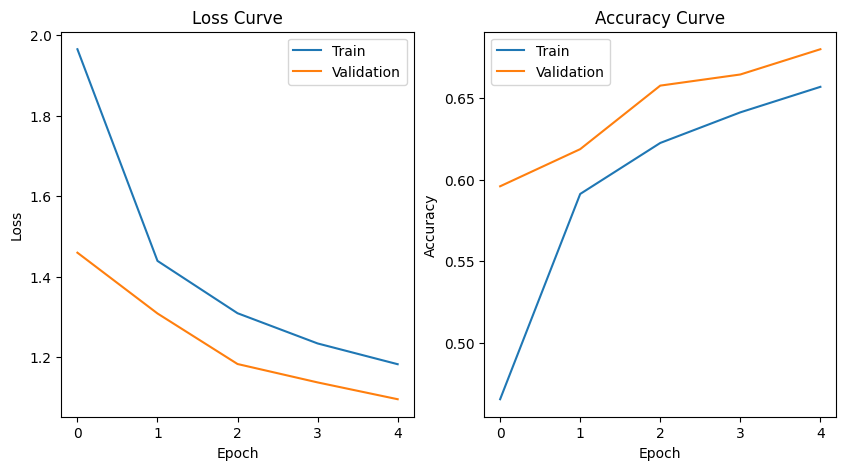

Stage 2: Training for 5 epochs

Epoch [1/5], Train Loss: 0.3924, Train Acc: 0.8780, Val Loss: 0.1603, Val Acc: 0.9457

Epoch [2/5], Train Loss: 0.1544, Train Acc: 0.9475, Val Loss: 0.1462, Val Acc: 0.9499

Epoch [3/5], Train Loss: 0.1138, Train Acc: 0.9612, Val Loss: 0.0910, Val Acc: 0.9688

Epoch [4/5], Train Loss: 0.0999, Train Acc: 0.9657, Val Loss: 0.0881, Val Acc: 0.9696

Epoch [5/5], Train Loss: 0.0874, Train Acc: 0.9704, Val Loss: 0.0688, Val Acc: 0.9772

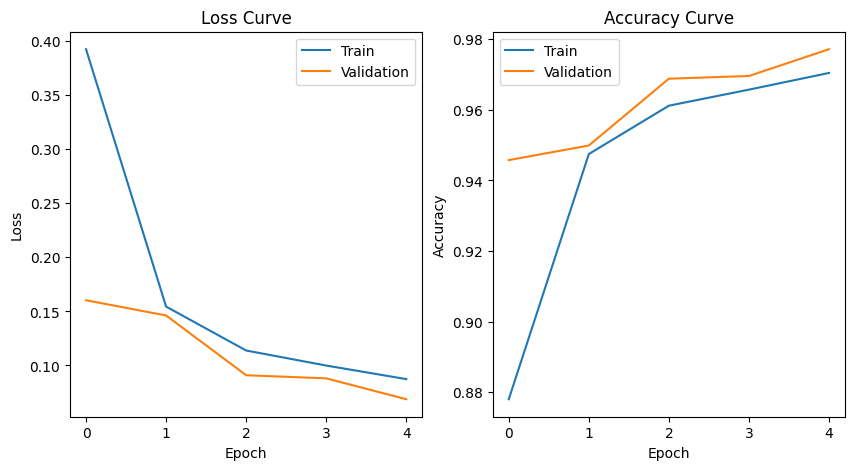

Stage 3: Training for 5 epochs

Epoch [1/5], Train Loss: 0.1923, Train Acc: 0.9366, Val Loss: 0.1167, Val Acc: 0.9594

Epoch [2/5], Train Loss: 0.1025, Train Acc: 0.9652, Val Loss: 0.0660, Val Acc: 0.9769

Epoch [3/5], Train Loss: 0.0850, Train Acc: 0.9712, Val Loss: 0.0760, Val Acc: 0.9730

Epoch [4/5], Train Loss: 0.0718, Train Acc: 0.9752, Val Loss: 0.0810, Val Acc: 0.9725

Epoch [5/5], Train Loss: 0.0637, Train Acc: 0.9784, Val Loss: 0.0429, Val Acc: 0.9848

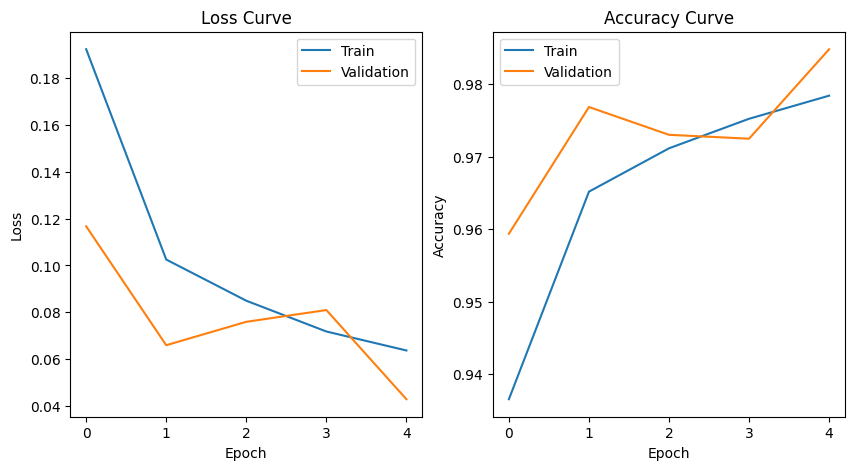

Stage 4: Training for 5 epochs

Epoch [1/5], Train Loss: 0.1056, Train Acc: 0.9650, Val Loss: 0.0554, Val Acc: 0.9802

Epoch [2/5], Train Loss: 0.0656, Train Acc: 0.9775, Val Loss: 0.0624, Val Acc: 0.9774

Epoch [3/5], Train Loss: 0.0569, Train Acc: 0.9810, Val Loss: 0.0523, Val Acc: 0.9814

Epoch [4/5], Train Loss: 0.0584, Train Acc: 0.9807, Val Loss: 0.0483, Val Acc: 0.9822

Epoch [5/5], Train Loss: 0.0535, Train Acc: 0.9819, Val Loss: 0.0486, Val Acc: 0.9831

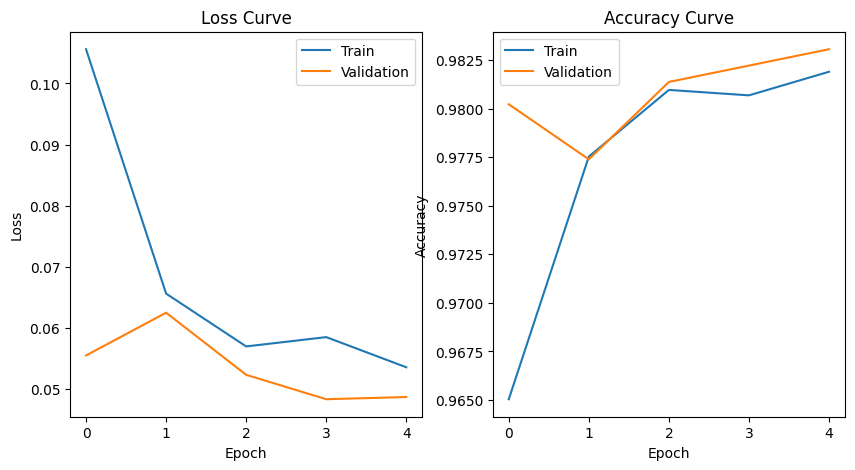

Stage 5: Training for 5 epochs

Epoch [1/5], Train Loss: 0.0608, Train Acc: 0.9796, Val Loss: 0.0536, Val Acc: 0.9821

Epoch [2/5], Train Loss: 0.0465, Train Acc: 0.9838, Val Loss: 0.0400, Val Acc: 0.9863

Epoch [3/5], Train Loss: 0.0459, Train Acc: 0.9849, Val Loss: 0.0644, Val Acc: 0.9792

Epoch [4/5], Train Loss: 0.0425, Train Acc: 0.9859, Val Loss: 0.0440, Val Acc: 0.9849

Epoch [5/5], Train Loss: 0.0391, Train Acc: 0.9869, Val Loss: 0.0667, Val Acc: 0.9769

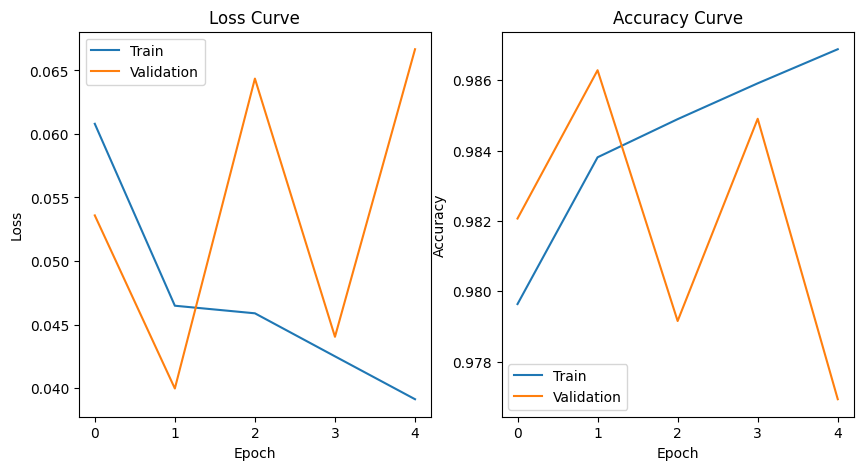

Test Loss: 0.0746, Test Acc: 0.9747

In [10]:
# Move the model to the device
model = model.to(device)

eta = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta)

# Train the model with progressive unfreezing
num_epochs = 5

for stage in range(5):  # ResNet-50 has 5 stages (including the final fully connected layer)
    
    print(f"Stage {stage + 1}: Training for {num_epochs} epochs")

    # Unfreeze layers up to the current stage
    if stage > 0:
        for param in model.module.layer4.parameters():
            param.requires_grad = True
    if stage > 1:
        for param in model.module.layer3.parameters():
            param.requires_grad = True
    if stage > 2:
        for param in model.module.layer2.parameters():
            param.requires_grad = True
    if stage > 3:
        for param in model.module.layer1.parameters():
            param.requires_grad = True
            
            
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)
    
    # Save the model
    save_dir = 'saved_stage_models'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"resnet50_stage_{stage + 1}.pth")
    torch.save(model.state_dict(), save_path)
    
    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    eta = eta/10
    
# Initialize empty lists to store test labels and predictions
test_labels = []
test_predictions = []

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        
        # Append test labels and predictions to the lists
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Convert lists to arrays
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

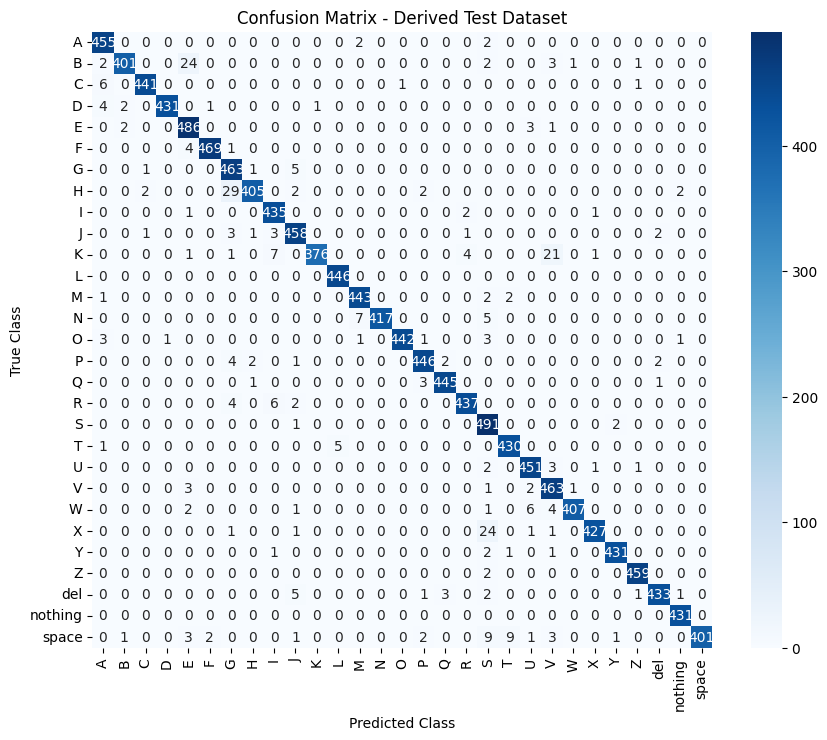

In [11]:
# Generate confusion matrix for the fine-tuned model
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Derived Test Dataset")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [12]:
root_dir = '/kaggle/input/asl-alphabet-test'
test_data = datasets.ImageFolder(root=root_dir, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=32)

In [13]:
# Initialize empty lists to store test labels and predictions
test_labels = []
test_predictions = []

# Test the model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        
        # Append test labels and predictions to the lists
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test / total_test
print("Final External Test Dataset Results: ")
print(f"Test Loss: {test_loss / len(test_dataloader):.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Convert lists to arrays
test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

Final External Test Dataset Results:

Test Loss: 10.6868, Test Acc: 0.1893

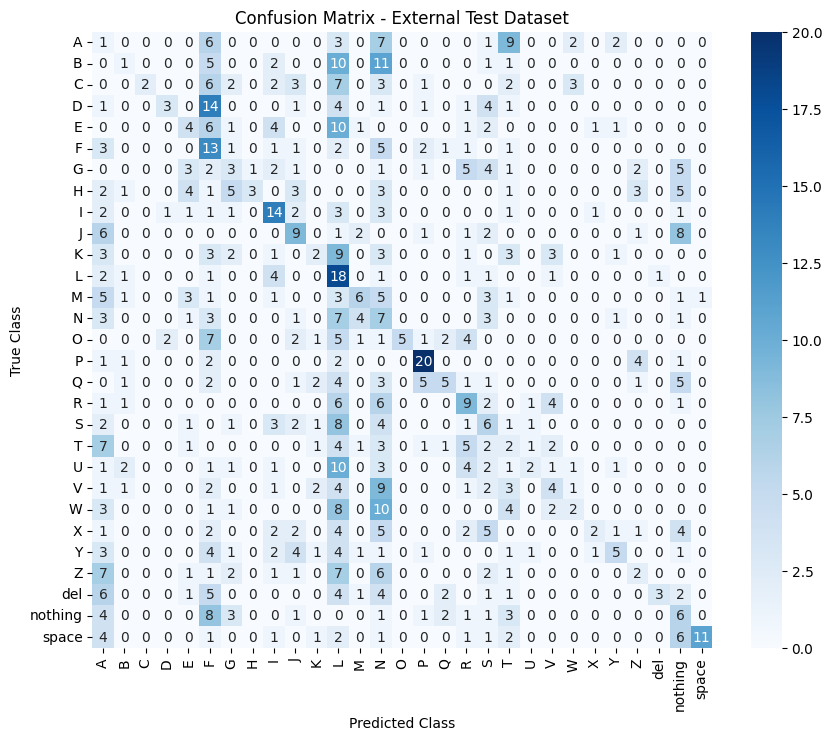

In [14]:
# Generate confusion matrix for the fine-tuned model
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix for the fine-tuned model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title("Confusion Matrix - External Test Dataset")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()